In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from linearmodels import IV2SLS
from linearmodels.iv.results import compare

In [50]:
# Load the data
data = pd.read_csv('../../data/combined_data/gvcomix_data.csv')
# Drop rows with missing values in any of the columns used in the regression
columns_to_check = ['onset2COWCS', 'decade', 'logpop_M_diff', 'logpopdens_diff', 
                    'logoutreg_diff', 'ecgrowth_demeaned', 'democracy_diff',
                    'oilreserves', 'logmountain', 'ethnic_fractionalization', 
                    'religion_fractionalization', 'language_fractionalization', 
                    'leg_british', 'opec']
# Replace infinite values with NaN
data[columns_to_check] = data[columns_to_check].replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN in these columns
data = data.dropna(subset=columns_to_check)

data = data.set_index(['country', 't'])

Oil Reserves Clustering

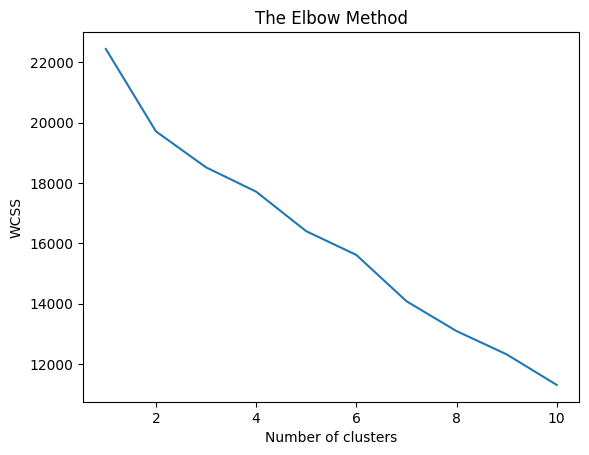

In [51]:

features = data[['oilreserves', 'onset2COWCS' 'decade', 'logpop_M_diff' , 'logpopdens_diff' , 'logoutreg_diff' , 'ecgrowth_demeaned', 'democracy_diff',
                 'logmountain'  ,'ethnic_fractionalization' , 'religion_fractionalization','language_fractionalization', 'leg_british' , 'opec']]  

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Calculating WCSS for a range of number of clusters
wcss = []
for i in range(1, 11):  # Testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the results to observe 'The Elbow'
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Pick K = 6

In [55]:
# Step 1: Create Clusters
kmeans = KMeans(n_clusters=3, random_state=0)
data['Cluster'] = kmeans.fit_predict(features_scaled)

# Step 2: Run Regression Analysis with Cluster Dummies
# Define the model formula including cluster dummies
formula = 'onset2COWCS ~ oilreserves + decade + logpop_M_diff + logpopdens_diff + logoutreg_diff + ecgrowth_demeaned + democracy_diff + logmountain + ethnic_fractionalization + religion_fractionalization + language_fractionalization + leg_british + opec + C(Cluster)'

# Fit the model
model = smf.ols(formula, data=data).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            onset2COWCS   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.827
Date:                Tue, 27 Feb 2024   Prob (F-statistic):             0.0269
Time:                        16:19:08   Log-Likelihood:                 718.50
No. Observations:                1147   AIC:                            -1405.
Df Residuals:                    1131   BIC:                            -1324.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

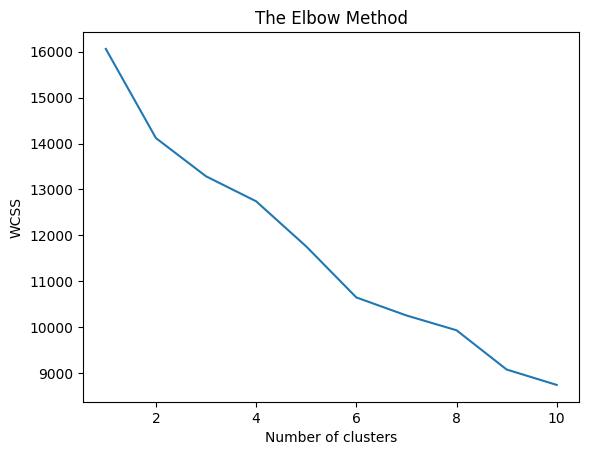

In [41]:

# relevant variables
features = data[['s6', 'onset2COWCS', 'decade', 'logpop_M_diff' , 'logpopdens_diff' , 'logoutreg_diff' , 'ecgrowth_demeaned', 'democracy_diff'
                 , 'logmountain'  ,'ethnic_fractionalization'  , 'religion_fractionalization','language_fractionalization', 'leg_british' , 'opec']]  

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Calculating WCSS for a range of number of clusters
wcss = []
for i in range(1, 11):  # Testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the results to observe 'The Elbow'
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [45]:
kmeans = KMeans(n_clusters=3, random_state=0)
data['Cluster'] = kmeans.fit_predict(features_scaled)


In [46]:
# Define the dependent variable
dependent = data['onset2COWCS']

# List of variables to regress on
variables = ['s1', 's2', 's6', 's10']

# Corresponding instrument variables for transport
instruments_transport = ['trans_outp_p', 'trans_outp_p', 'trans_outp_p', 'trans_outp_p']

# Corresponding instrument variables for World GVC
instruments_gvc = ['avgs1', 'avgs2', 'avgs6', 'avgs10']

# DataFrame to store results
results_data = []

# Loop through each variable and its corresponding instrument and run the regression for both instruments
for var, inst_transport, inst_gvc in zip(variables, instruments_transport, instruments_gvc):
    for inst, inst_name in zip([inst_transport, inst_gvc], ["transport", "World GVC"]):
        formula = 'onset2COWCS ~ 1 + [' + var + ' ~ ' + inst + '] + decade + logpop_M_diff + logpopdens_diff + logoutreg_diff + ecgrowth_demeaned + democracy_diff + C(Cluster)'
        model_iv = IV2SLS.from_formula(formula, data)
        results_iv = model_iv.fit(cov_type='clustered', clusters=data.index.get_level_values('country'))
        #print(results_iv)
        # Add the results to the list
        results_data.append({
            'Variable': var,
            'Instrument': inst_name,
            'Coefficient': results_iv.params[var],
            'Std Error': results_iv.std_errors[var],
            'P-value': results_iv.pvalues[var]
        })

# Convert list to DataFrame and set the MultiIndex
results_df = pd.DataFrame(results_data)
results_df = results_df.set_index(['Variable', 'Instrument'])


# Output to file
results_df.to_csv('mix_results.csv')